
[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


FileUpload(value=(), accept='image/*', description='Upload')

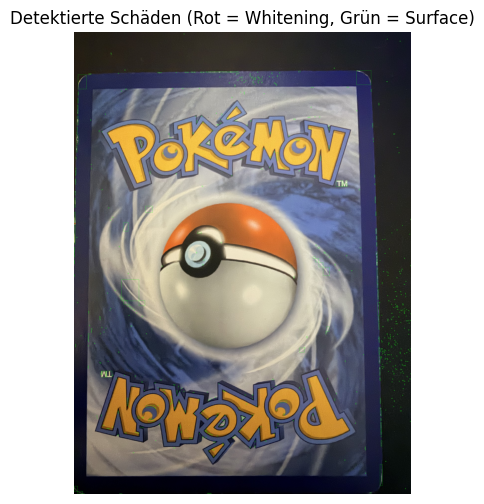

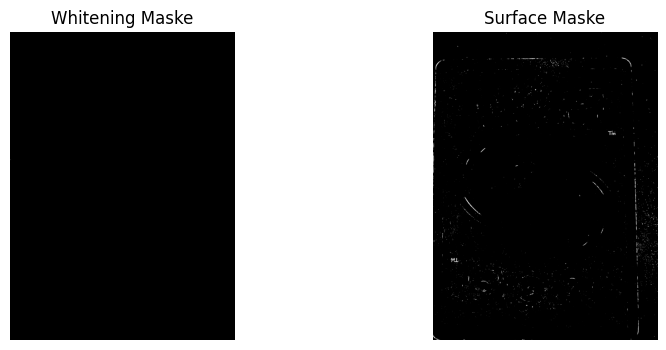

In [11]:
%pip install --quiet ipywidgets opencv-python-headless matplotlib

from ipywidgets import FileUpload
from IPython.display import display
import cv2
import numpy as np
import matplotlib.pyplot as plt

def order_points(pts):
    # sortiert die 4 Eckpunkte in (top-left, top-right, bottom-right, bottom-left)
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # top-left
    rect[2] = pts[np.argmax(s)]  # bottom-right

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left
    return rect

def extract_card(image, output_size=None):
    """
    Extrahiert die Karte über die blaue Rückseiten-Farbe.
    Erwartet: Pokemon-Rückseite (blauer Rand) auf einem anderen Hintergrund.
    image: BGR-Bild (so wie von cv2.imdecode eingelesen)
    """
    # BGR -> HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Blau-Bereich (kann man später tunen)
    # H: 0–179, S/V: 0–255 in OpenCV
    lower_blue = np.array([90, 60, 40], dtype=np.uint8)
    upper_blue = np.array([140, 255, 255], dtype=np.uint8)

    # Maske für blaue Bereiche (Kartenrand + viel vom Hintergund der Rückseite)
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # kleine Löcher schließen / Kanten verbinden
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # größte zusammenhängende Fläche = Karte
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError(
            "Konnte keine blaue Kartenfläche finden. "
            "Ist es die Rückseite einer Pokémon-Karte und ist sie gut beleuchtet?"
        )

    card_cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(card_cnt)
    card = image[y:y+h, x:x+w]

    # Optional auf eine feste Größe skalieren
    if output_size is not None:
        card = cv2.resize(card, output_size, interpolation=cv2.INTER_AREA)

    return card

def detect_whitening(card, border_width=25, l_thresh=210):
    """
    Sucht im Randbereich der Karte nach hellen Spots (Whitening).
    """
    lab = cv2.cvtColor(card, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    h, w = L.shape

    mask = np.zeros_like(L, dtype=np.uint8)
    bw = border_width
    mask[:bw, :] = 255
    mask[h - bw:, :] = 255
    mask[:, :bw] = 255
    mask[:, w - bw:] = 255

    bright = cv2.bitwise_and(L, L, mask=mask)

    _, th = cv2.threshold(bright, l_thresh, 255, cv2.THRESH_BINARY)

    kernel = np.ones((3, 3), np.uint8)
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for c in contours:
        area = cv2.contourArea(c)
        if area < 5:
            continue
        x, y, ww, hh = cv2.boundingRect(c)
        boxes.append((x, y, ww, hh))

    return boxes, th


def detect_surface_defects(card, min_area=10):
    """
    Sehr grobe Detektion von hellen kleinen Oberflächendefekten.
    """
    gray = cv2.cvtColor(card, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    tophat = cv2.morphologyEx(blur, cv2.MORPH_TOPHAT, kernel)

    _, th = cv2.threshold(tophat, 15, 255, cv2.THRESH_BINARY)
    th = cv2.medianBlur(th, 3)

    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for c in contours:
        area = cv2.contourArea(c)
        if area < min_area:
            continue
        x, y, w, h = cv2.boundingRect(c)
        boxes.append((x, y, w, h))

    return boxes, th

def draw_boxes(card, whitening_boxes, surface_boxes):
    vis = card.copy()

    # Whitening = rot
    for (x, y, w, h) in whitening_boxes:
        cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # Surface-Defects = grün
    for (x, y, w, h) in surface_boxes:
        cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 1)

    return vis

uploader = FileUpload(accept='image/*', multiple=False)
display(uploader)

def process_upload(change):
    # In neueren ipywidgets-Versionen ist uploader.value ein Tuple von UploadedFile-Objekten
    if not uploader.value:
        return

    # erstes (und einziges) File nehmen
    uploaded_file = uploader.value[0]

    # Es gibt zwei mögliche Strukturen: dict oder Objekt mit Attributen
    if isinstance(uploaded_file, dict):
        content = uploaded_file["content"]
    else:
        # ipywidgets 8: UploadedFile-Objekt mit .content
        content = uploaded_file.content

    # in NumPy-Array und mit OpenCV dekodieren
    np_arr = np.frombuffer(content, np.uint8)
    image = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)

    if image is None:
        print("Konnte das Bild nicht dekodieren. Ist es wirklich ein Bild?")
        return

    try:
        card = extract_card(image)
    except Exception as e:
        print("Fehler bei Kartenerkennung:", e)
        return

    whitening_boxes, white_mask = detect_whitening(card)
    surface_boxes, surf_mask = detect_surface_defects(card)

    vis = draw_boxes(card, whitening_boxes, surface_boxes)

    # Ergebnis anzeigen (BGR -> RGB)
    plt.figure(figsize=(10, 6))
    plt.title("Detektierte Schäden (Rot = Whitening, Grün = Surface)")
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    # Optional: Masken anzeigen
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].set_title("Whitening Maske")
    axs[0].imshow(white_mask, cmap='gray')
    axs[0].axis("off")

    axs[1].set_title("Surface Maske")
    axs[1].imshow(surf_mask, cmap='gray')
    axs[1].axis("off")

    plt.show()

# Observer registrieren
uploader.observe(process_upload, names='value')

